# 7주차 실습: 위성 이미지 분석 (다운로드, 시각화, 처리)
이 실습에서는 requests 라이브러리로 샘플 위성 이미지를 다운로드하고, rasterio로 데이터를 읽어 메타정보를 확인합니다. 그 다음, matplotlib으로 원본 이미지를 먼저 시각화해보고, numpy를 이용해 식생지수(NDVI)를 계산한 후, 최종 분석 결과를 다시 시각화하는 전체 과정을 단계별로 진행합니다.

## 셀 1: 필요 라이브러리 설치 및 임포트
먼저 실습에 필요한 라이브러리들을 설치하고 임포트합니다.

In [1]:
# 라이브러리가 설치되지 않은 경우 아래 주석을 해제하고 실행하세요.
# !pip install rasterio matplotlib numpy requests

import rasterio
import numpy as np
import matplotlib.pyplot as plt
import requests
import os

## 셀 2: 샘플 위성 데이터 다운로드
실습에 사용할 GeoTIFF 형식의 샘플 위성 이미지를 웹에서 다운로드하여 현재 폴더에 저장합니다.

In [2]:
# 실습에 사용할 Landsat 8 샘플 이미지(GeoTIFF)를 다운로드합니다.
url = 'https://github.com/rasterio/rasterio/raw/main/tests/data/RGB.byte.tif'
file_name = 'sample_satellite_image.tif'

print(f"'{file_name}' 다운로드를 시작합니다...")

if not os.path.exists(file_name):
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()
        with open(file_name, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print("다운로드 완료!")
    except requests.exceptions.RequestException as e:
        print(f"다운로드 중 오류가 발생했습니다: {e}")
else:
    print("파일이 이미 존재합니다. 다운로드를 건너뜁니다.")

'sample_satellite_image.tif' 다운로드를 시작합니다...
파일이 이미 존재합니다. 다운로드를 건너뜁니다.


## 셀 3: 원본 이미지 데이터 읽기 및 시각화
다운로드한 TIF 파일을 rasterio로 열고, 먼저 RGB(Red, Green, Blue) 밴드를 조합하여 실제 우리 눈에 보이는 것과 유사한 '자연색(True Color)' 이미지로 시각화합니다.

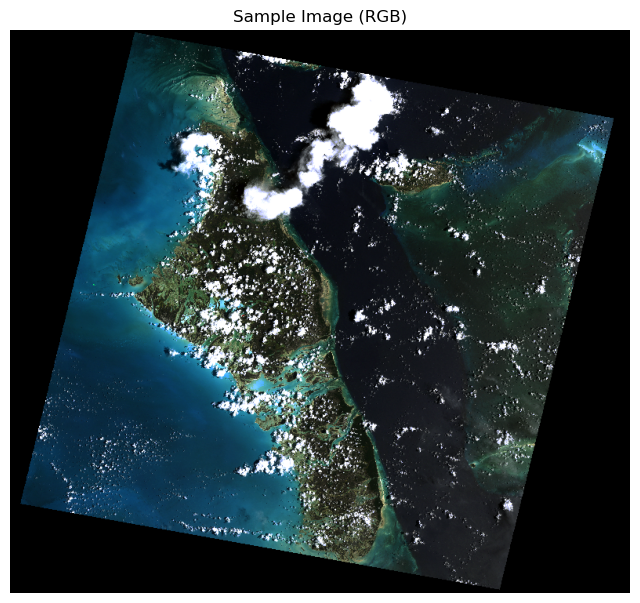

In [3]:
try:
    with rasterio.open(file_name) as src:
        # 시각화를 위해 RGB 밴드를 읽어옵니다. (밴드 1, 2, 3)
        red = src.read(1)
        green = src.read(2)
        blue = src.read(3)

        # Matplotlib에서 RGB 이미지를 표시하기 위해 (높이, 너비, 밴드) 형태로 배열을 재구성합니다.
        rgb_composite = np.dstack((red, green, blue))

        # 원본 이미지 시각화
        plt.figure(figsize=(8, 8))
        plt.imshow(rgb_composite)
        plt.title('Sample Image (RGB)')
        plt.axis('off')
        plt.show()

except FileNotFoundError:
    print(f"'{file_name}'을 찾을 수 없습니다. 이전 셀에서 다운로드가 완료되었는지 확인하세요.")

## 셀 4: 메타정보 확인 및 데이터 구조(Matrix) 확인
이제 이미지의 상세 정보(메타데이터)를 확인합니다. 밴드 수, 이미지 크기, 좌표계 등을 통해 데이터의 기본 특성을 파악할 수 있습니다. 또한, 이미지 데이터가 실제로 어떻게 숫자로 구성되어 있는지 확인하기 위해 numpy 배열(행렬)의 일부를 직접 출력해 봅니다.

In [5]:
with rasterio.open(file_name) as src:
    print("--- 위성 이미지 메타정보 ---")
    print(f"밴드 수: {src.count}")
    print(f"이미지 너비: {src.width} 픽셀")
    print(f"이미지 높이: {src.height} 픽셀")
    print(f"좌표 참조 시스템(CRS): {src.crs}")

    # Red 밴드 데이터를 Numpy 배열로 읽어옵니다.
    red_band_matrix = src.read(1)

    print("\n--- 데이터 구조 (Red 밴드의 좌측 상단 5x5 픽셀 값) ---")
    print(red_band_matrix[:5, :5])

--- 위성 이미지 메타정보 ---
밴드 수: 3
이미지 너비: 791 픽셀
이미지 높이: 718 픽셀
좌표 참조 시스템(CRS): PROJCS["WGS 84 / UTM zone 18N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]

--- 데이터 구조 (Red 밴드의 좌측 상단 5x5 픽셀 값) ---
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


## 셀 5: 데이터 처리 - NumPy로 NDVI 계산하기
NDVI(정규화 식생 지수)는 식물의 활력도를 분석하는 데 널리 사용되는 지표입니다. 근적외선(NIR)과 적색(Red) 밴드의 반사율 차이를 이용해 계산합니다.

NDVI = (NIR - Red) / (NIR + Red)

참고: 이 샘플 이미지는 NIR 밴드를 포함하고 있지 않습니다. 따라서 실습을 위해 Red 밴드를 NIR로, Green 밴드를 Red로 가정하여 NDVI 계산을 시연합니다.

In [6]:
with rasterio.open(file_name) as src:
    # 밴드 데이터를 float 형태로 다시 읽어와서 계산 준비
    red = src.read(1).astype(float)
    green = src.read(2).astype(float)
    
    # NIR, Red 밴드 가정
    nir = red
    red_for_ndvi = green

# NumPy를 이용한 NDVI 계산
# 분모가 0이 되는 경우를 방지합니다.
denominator = nir + red_for_ndvi
ndvi = np.where(denominator > 0, (nir - red_for_ndvi) / denominator, 0)

print("NDVI 계산 완료!")
print(f"계산된 NDVI 행렬의 일부 (좌측 상단 5x5):\n{ndvi[:5, :5]}")

NDVI 계산 완료!
계산된 NDVI 행렬의 일부 (좌측 상단 5x5):
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_71320\2415627508.py:13: RuntimeWarning: invalid value encountered in true_divide
  ndvi = np.where(denominator > 0, (nir - red_for_ndvi) / denominator, 0)


## 셀 6: 최종 결과 시각화
마지막으로, 원본 이미지와 우리가 직접 계산한 NDVI 분석 결과를 나란히 비교하여 시각화합니다. NDVI 맵에서는 일반적으로 녹색이 진할수록 식생이 활발함을 의미합니다.

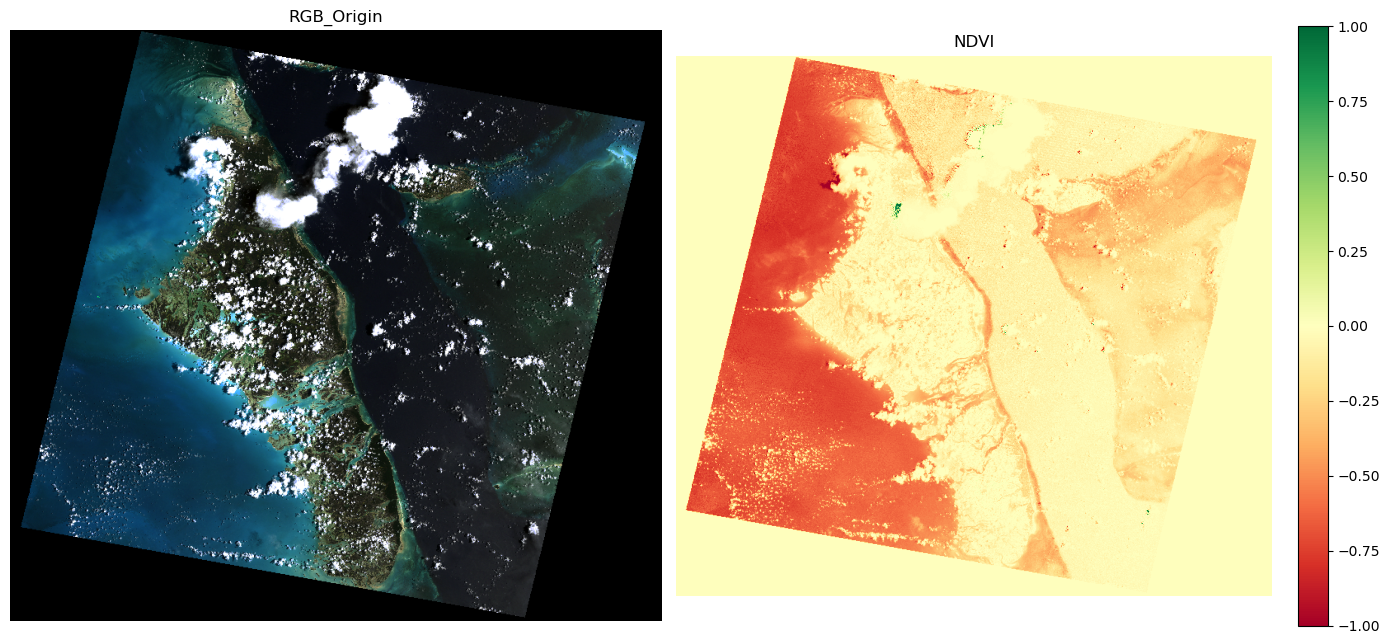

In [9]:
# 시각화 객체 생성 (1행 2열)
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# 1. 원본 RGB 이미지 출력
axes[0].imshow(rgb_composite)
axes[0].set_title('RGB_Origin')
axes[0].axis('off')

# 2. NDVI 결과 출력
im = axes[1].imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
axes[1].set_title('NDVI')
axes[1].axis('off')

# 컬러바 추가
fig.colorbar(im, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()